<a href="https://colab.research.google.com/github/swapnamoy007/ML-ASSIGNMENT/blob/main/Module_9/Final_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# II. What's in that image?

Analysis of metallographic images by the variational autoencoder (VAE) based segmentation.
- Data by Vivek Chawla

In [2]:
!gdown https://drive.google.com/file/d/12c2C-tGC5JQBgoLJvHNLl8MPnuWamell/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=12c2C-tGC5JQBgoLJvHNLl8MPnuWamell
To: /content/Main image_C-Laser DIC_20241119170035.png
100% 4.00M/4.00M [00:00<00:00, 47.6MB/s]


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_name = '/content/Main image_C-Laser DIC_20241119170035.png'
color_image = cv2.imread(image_name)
image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
print(f'dtype: {image.dtype}, shape: {image.shape}, min: {np.min(image)}, max: {np.max(image)}')

height, width = image.shape
# Calculate the cropping coordinates
crop_height = height - 200
# Crop the image
cropped_image = image[:crop_height, :]
#cropped_image = image[800:, 250:850]

# optional CLAHE
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(200, 200))
image = clahe.apply(cropped_image)

dtype: uint8, shape: (1536, 2048), min: 0, max: 255


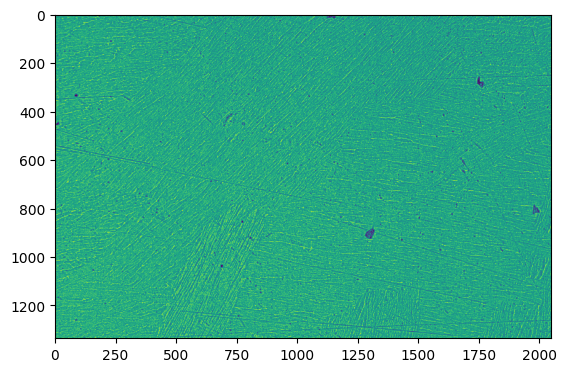

In [4]:
plt.imshow(image)

The metallograpic image clearly has the regions visible to human eye. Build the ML image analysis workflow that will allow segmenting the image into visible regions. The strategies you can explore are:
1. Image featurization - e.g. edge finding
2. Sliding widow feature fuilding vs. keypoitn detection
3. Human heuristic - defining features (note that ChatGPT can be very helpful)
4. Dimensionality reduction
5. Have fun!

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 478ms/step - accuracy: 0.7886 - loss: 0.6078 - val_accuracy: 0.7886 - val_loss: 0.5181
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7886 - loss: 0.5230 - val_accuracy: 0.7886 - val_loss: 0.5205
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7886 - loss: 0.5188 - val_accuracy: 0.7886 - val_loss: 0.5196
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7886 - loss: 0.5187 - val_accuracy: 0.7886 - val_loss: 0.5178
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7886 - loss: 0.5175 - val_accuracy: 0.7886 - val_loss: 0.5172
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7886 - loss: 0.5171 - val_accuracy: 0.7886 - val_loss: 0.5169
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7886 - loss: 0.5167 - val_accuracy: 0.7886 - val_loss: 0.5168
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7886 - loss: 0.5166 - val_accuracy: 0.7886 - val_loss: 0.516

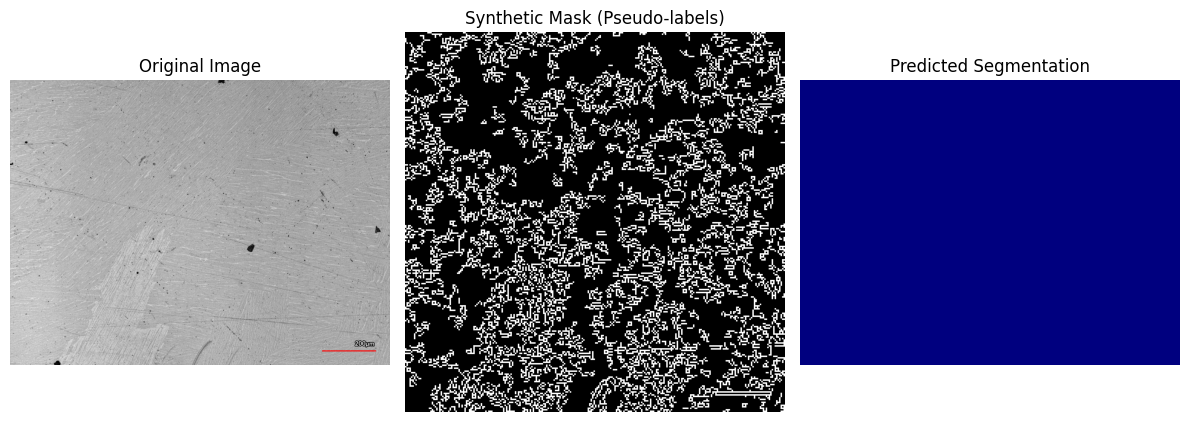

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Load and Preprocess Image
image_name = '/content/Main image_C-Laser DIC_20241119170035.png'
color_image = cv2.imread(image_name)

if color_image is None:
    raise FileNotFoundError(f"Image not found: {image_name}")

input_size = (256, 256)
original_size = color_image.shape[:2]
resized_image = cv2.resize(color_image, input_size)
normalized_image = resized_image / 255.0

# Synthetic mask generation
gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray_image, 50, 150)
edges_resized = cv2.resize(edges, input_size)
segmentation_mask = (edges_resized > 0).astype(np.uint8)
segmentation_mask = to_categorical(segmentation_mask, num_classes=2)

# Step 2: Augment Data
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Expand dimensions for compatibility
X = np.expand_dims(normalized_image, axis=0)  # Add batch dimension
Y = np.expand_dims(segmentation_mask, axis=0)

# Generate augmented samples
X_augmented = []
Y_augmented = []

for _ in range(20):  # Generate 20 augmented samples
    for x_batch, y_batch in datagen.flow(X, Y, batch_size=1):
        X_augmented.append(x_batch[0])
        Y_augmented.append(y_batch[0])
        break  # Exit after one batch

X_augmented = np.array(X_augmented)
Y_augmented = np.array(Y_augmented)

# Step 3: Split Data
X_train, X_val, Y_train, Y_val = train_test_split(X_augmented, Y_augmented, test_size=0.2, random_state=42)

# Step 4: Define U-Net Model
def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)

    # Decoder
    u1 = UpSampling2D((2, 2))(c3)
    d1 = concatenate([u1, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(d1)

    u2 = UpSampling2D((2, 2))(c4)
    d2 = concatenate([u2, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(d2)

    outputs = Conv2D(2, (1, 1), activation='softmax')(c5)

    model = Model(inputs, outputs)
    return model

unet_model = build_unet((256, 256, 3))
unet_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the Model
history = unet_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=2)

# Step 6: Predict and Visualize Segmentation
predictions = unet_model.predict(np.expand_dims(normalized_image, axis=0))

# Convert predicted probabilities to class labels
predicted_mask = np.argmax(predictions[0], axis=-1)

# Resize the mask back to original image size
final_mask = cv2.resize(predicted_mask.astype(np.uint8), original_size[::-1])

# Step 7: Visualization
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Synthetic Mask
plt.subplot(1, 3, 2)
plt.title("Synthetic Mask (Pseudo-labels)")
plt.imshow(edges, cmap='gray')
plt.axis('off')

# Predicted Mask
plt.subplot(1, 3, 3)
plt.title("Predicted Segmentation")
plt.imshow(final_mask, cmap='jet')
plt.axis('off')

plt.tight_layout()
plt.show()


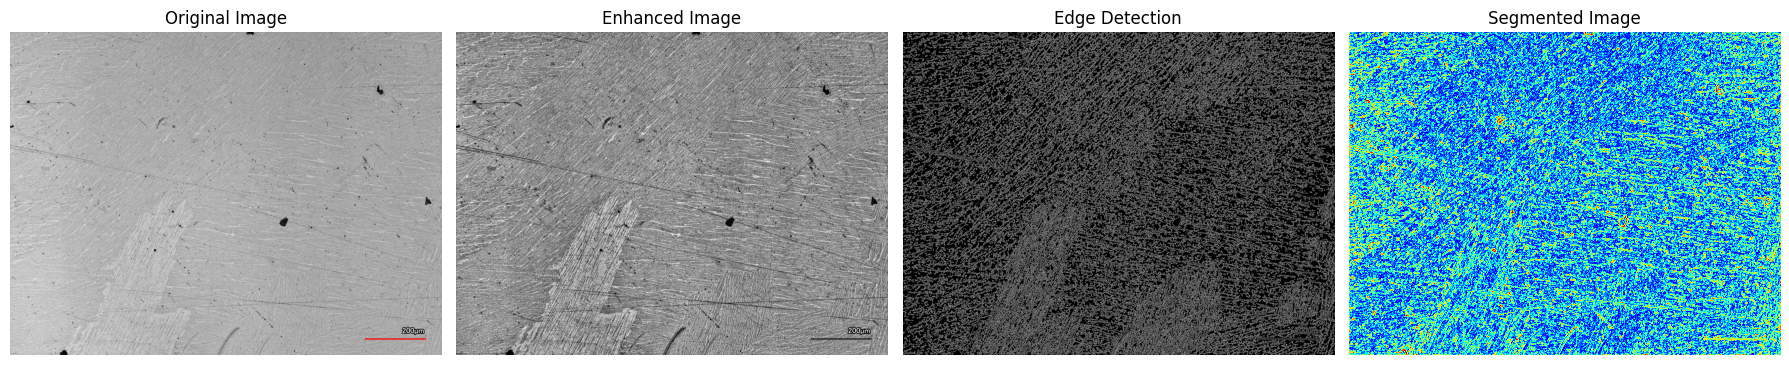

Segmented image saved to: segmented_metallographic_image.png


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load Image
image_name = '/content/Main image_C-Laser DIC_20241119170035.png'
color_image = cv2.imread(image_name)

if color_image is None:
    raise FileNotFoundError(f"Image not found: {image_name}")

# Convert to Grayscale
gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

# Step 1: Preprocessing
# Apply CLAHE for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
enhanced_image = clahe.apply(gray_image)

# Gaussian Blur for noise reduction
blurred_image = cv2.GaussianBlur(enhanced_image, (5, 5), 0)

# Step 2: Edge Detection
edges = cv2.Canny(blurred_image, 100, 200)

# Step 3: Texture Feature Extraction using Local Binary Pattern (LBP)
radius = 3  # Radius of circular neighborhood
n_points = 8 * radius  # Number of points in the LBP
lbp_image = local_binary_pattern(blurred_image, n_points, radius, method="uniform")

# Create additional texture features (e.g., normalized LBP histogram)
def compute_lbp_histogram(image, bins=10):
    hist, _ = np.histogram(image.ravel(), bins=bins, range=(0, bins))
    hist = hist.astype("float")
    hist /= hist.sum()  # Normalize histogram
    return hist

# Generate texture features for each pixel neighborhood
texture_features = [lbp_image]

# Resize texture features to match image dimensions
texture_features_resized = [
    cv2.resize(feature, (blurred_image.shape[1], blurred_image.shape[0]), interpolation=cv2.INTER_NEAREST)
    for feature in texture_features
]

# Combine Edge and Texture Features
combined_features = np.dstack([blurred_image / 255.0, edges / 255.0, *texture_features_resized])

# Step 4: Dimensionality Reduction
# Reshape combined features for PCA
reshaped_features = combined_features.reshape(-1, combined_features.shape[-1])

# Apply PCA
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(reshaped_features)

# Step 5: Clustering
# K-Means Clustering for segmentation
n_clusters = 3  # Number of visible regions
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(reduced_features)

# Reshape labels back to image dimensions
segmented_image = labels.reshape(gray_image.shape)

# Step 6: Post-Processing
# Apply morphological closing to refine segmentation
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
refined_segmentation = cv2.morphologyEx(segmented_image.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

# Step 7: Visualization
plt.figure(figsize=(18, 6))

# Original Image
plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Enhanced Image
plt.subplot(1, 4, 2)
plt.title("Enhanced Image")
plt.imshow(enhanced_image, cmap='gray')
plt.axis('off')

# Edge Detection
plt.subplot(1, 4, 3)
plt.title("Edge Detection")
plt.imshow(edges, cmap='gray')
plt.axis('off')

# Segmented Image
plt.subplot(1, 4, 4)
plt.title("Segmented Image")
plt.imshow(segmented_image, cmap='jet')
plt.axis('off')

plt.tight_layout()
plt.show()

# Save the segmented image
output_path = 'segmented_metallographic_image.png'
cv2.imwrite(output_path, (segmented_image * (255 // n_clusters)).astype(np.uint8))
print(f"Segmented image saved to: {output_path}")


An example of possible answer:

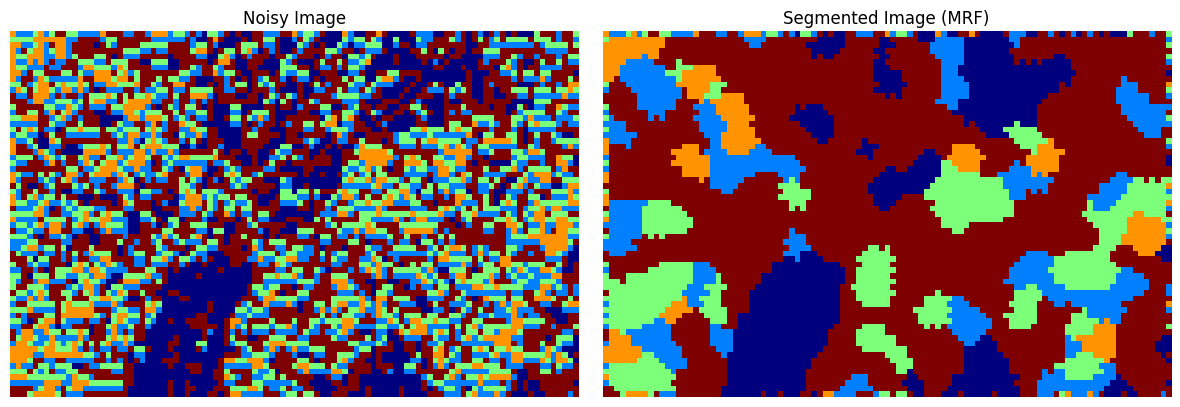

# III. Causality in materials science

III.1. Explain the concept of causality and its significance in understanding material properties and behaviors.

Answer:

III.2. Describe what a confounder is and give an example of a potential confounder in an experiment involving the study of corrosion resistance in alloys.

Answer:

III.3. Identify a causal chain in the process of polymer degradation and point out any potential confounders that could affect the results.

Answer:

III.4. Provide an example from materials science where a correlation between two variables does not imply causation, explaining the role of potential confounders.

Answer:

III.5. Discuss how grain size and impurity levels can act as confounders in the analysis of a metal’s mechanical properties.

Answer:

III.6. How might temperature influence the electrical conductivity of a material, and what are potential confounders in this relationship?

Answer:

III.7. Explain what collider bias is and provide an example of how it might occur in materials science research.

Answer:

III.8. Discuss how colliders can lead to incorrect interpretations in studies related to material fatigue and lifespan.

Answer:

III.9. Describe challenges in establishing causality in machine learning models used in materials science and the importance of identifying confounders and colliders.

Answer:

III.10. How would you design an experiment to reveal the causal relationship between processing conditions and the final microstructure of a ceramic material, considering potential confounders and colliders?

Answer:

# IV. Analysis of atomic images

Based on the notebooks by Maxim Ziatdinov, ziatdinovmax@gmail.com

In [ ]:
!pip install git+https://github.com/pycroscopy/atomai # install the latest version from source

Imports:

In [ ]:
import atomai as aoi
import numpy as np
import matplotlib.pyplot as plt

Download training/test data:

In [ ]:
# !wget -O "Hex_train_test3.npz" https://www.dropbox.com/s/aldxrawcf88btkc/Hex_train_test3.npz?dl=0

In [ ]:
download_link1 = 'https://drive.google.com/uc?id=1-4-IQ71m--OelQb1891GnbG1Ako1-DKh'
download_link2 = 'https://drive.google.com/uc?id=18JK9GcMPMWHmHtwArujVQRLr6N4VIM_j'

!gdown -q $download_link1 -O 'training_data.npy'
!gdown -q $download_link2 -O 'validation_data.npy'

# Load train/test data (this is a simple dataset generated just from a single image)
dataset = np.load('training_data.npy')
images = dataset['X_train']
labels = dataset['y_train']
images_test = dataset['X_test']
labels_test = dataset['y_test']

# Load validation data (data from different experiment)
expdata = np.load("validation_data.npy")


In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/14CGHXHfca4FsQjzVCOPkE6IpokE9fwC-/view?usp=sharing # bto_atomic.jpg

In [ ]:
'''
# Load train/test data (this is a simple dataset generated just from a single image)
dataset = np.load("Hex_train_test3.npz")
images = dataset["X_train"]
labels = dataset["y_train"]
images_test = dataset["X_test"]
labels_test = dataset["y_test"]
'''

In [ ]:
print(images.shape, labels.shape)
print(images_test.shape, labels_test.shape)

In [ ]:
n = 15

fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[n,0,:,:])
ax[1].imshow(labels[n,:,:])
plt.show()



```
# This is formatted as code
```

## Problem IV.1

IV.1. Create a data set of images and labels by slicing the original training set. For example, you can simply select 64x64 window from both images, labels, images_test and labels_test data sets. Make sure to use different name, so that we keep original data sets for later.

IV.2. Create a neural network that learns to segment the 64x64 images, meaning to predict labels based on inputs.

IV.3. Train the network and explore the training/validation curve.

Now, let's download experimental image.

In [ ]:
# Load validation data (data from different experiment)
expdata = plt.imread('bto_atomic.jpg')
plt.imshow(expdata, cmap='gray')

IV.4. Now, select the segment of the image (experiment with resizing and slicing) and see if your network can find atoms on this image.

Now, let's compare the results with the "official" AtomAI solution.

Note that the training/test images and masks represent 4 separate numpy arrays with the dimensions (n_images, n_channels=1, image_height, image_width) for training/test images, and (n_images, image_height, image_width) for the associated masks (aka ground truth). The reason that our images have 4 dimensions, while our labels have only 3 dimensions is because of how the cross-entropy loss is calculated in PyTorch (see [here](https://pytorch.org/docs/stable/nn.html#nllloss)). Briefly, if you have multiple channels corresponding to different classes in your labeled data, you'll need to map your target classes to tensor indices. Here, we already did this for our training and test data during the preparation stage and so everything is ready for training.

Let's plot some of the original training data:

In [ ]:
n = 5 # number of images to plot

n = n + 1
fig = plt.figure( figsize=(30, 8))
for i in range(1, n):
    ax = fig.add_subplot(2, n, i)
    ax.imshow(images[i-1,0,:,:], cmap='gray')
    ax.set_title('Augmented image ' + str(i))
    ax.grid(alpha = 0.5)
    ax = fig.add_subplot(2, n, i+n)
    ax.imshow(labels[i-1], interpolation='Gaussian', cmap='jet')
    ax.set_title('Ground truth ' + str(i))
    ax.grid(alpha=0.75)

The neural network will be trained to take the images in the top row (see plot above) as the input and to output clean images of circular-shaped "blobs" on a uniform background in the bottom row, from which one can identify the xy centers of atoms.

We are going to use a [UNet](https://en.wikipedia.org/wiki/U-Net)-like neural network for semantic segmentation. In the semantic segmentation tasks we aim at categorizing every pixel in the image. This is different form a regular image-level classification tasks, where we categorize the image as whole (e.g. this image has a cat/dog, etc.). Here's a nice illustration from this [free book](https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf):

<img src="https://drive.google.com/uc?export=view&id=18N4x3P0whH91OcpBOOkDprgWVo-36i34" width=800 px><br><br>

Initialize a nodel for semantic segmentation:

In [ ]:
model = aoi.models.Segmentor(nb_classes=3)

We can also "print" the neural network:

In [ ]:
print(model.net)

Train the initialized model:

(Here the accuracy is calculated as [Intersection over Union](https://en.wikipedia.org/wiki/Jaccard_index) (IoU) score, which is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between them)

In [ ]:
model.fit(images, labels, images_test, labels_test, # training data
          training_cycles=300, compute_accuracy=True, swa=True # training parameters
)

Now let's make a prediction on the image from a different experiment ( the data is from our paper in *Applied Physics Letters 115, 052902 (2019)* ). Notice that the raw output is a set of semantically segmented blobs (corresponding to different atoms) on a uniform background. We then simply find their centers of the mass, which correspond to the atomic centers (if a network was properly trained).

In [ ]:
nn_output, coordinates = model.predict(expdata)

In [ ]:
coordinates[0].shape

Plot raw prediction:

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))
ax1.imshow(expdata, cmap='gray', origin="lower")
ax2.imshow(nn_output.squeeze(), origin="lower")

Plot atomic coordinates:

In [ ]:
aoi.utils.plot_coord(expdata, coordinates[0], fsize=12)

Looks like our model performed quite well on the previously unseen data! There is no ground truth for the experimental data, so evaluating accuracy is somewhat tricky, but we can sometimes compare our results with the results of other methods.

Notice that here we analyzed image with resolution of 1024x1024 even though our network was trained only using 256x256 images. That's the beauty of fully convolutional neural networks (i.e. network without full-connected, dense layers) - it is not sensitive to the size of input image as long as it can be divided by $2^{n}$ where n is a number of max-pooling layers in the network. That said, there is always some optimal pixel-to-angstrom ratio (or, roughly, number of pixels per atom/defect) at which a network will generate the best results. It might be a good idea to determine such a ratio and (if possible) make adjustments to the resolution of experimental images.

Finally, please keep in mind that the model was trained onnly on a single image, so it may not be very robust or generalize well enough. However, the procedure for training on the larger and more diverse training set is exactly the same!

## Problem IV.2.

IV.4. Use the log-blob (Laplacian of Gaussian) to find atoms in the image

IV.5. Plot intensity of each atom as a function of position, i.e. make image A(xi, yi), where xi, yi are coordinates of atoms

Note that with this approach, we can identify image patches and perform all the supervised and unsupervised analyses. However, before doing it let's experiment with atom finding using AtomAI neural network we have trained.

## Problem IV.3.

Once we have all atomic coordinates and "cleaned" images we can perform various forms of analysis on local image descriptors. We start by get local descriptors, which are subimages centered on one of the sublattices:

In [ ]:
imstack = aoi.stat.imlocal(nn_output, coordinates, window_size=32, coord_class=1)

In [ ]:
# You can explore what's inside imstack object using the .*?
# imstack.*?

The imstack object encodes functions and methods in AtomAI. For our purposes, let's just create the arrays containign image patches and coordinates that they are taken from.

In [ ]:
imstack.imgstack.shape, imstack.imgstack_com.shape

IV.6. Plot the atoms you have found with log-blob in blue, and with neural network in red. Which method worked better?

IV.7. Use GMM to analyze the image patches,
- plot the class labels, and
- plot the labelled images (i.e. label at coordinates coming from imgstack_com)  

IV.8. Run the PCA analysis. Plot the:
- scree plot
- PCA components
- PCA images (meaning PCA1, PCA2, etc. for location in coordinates)

IV.9. Run similar analysis using variational autoencoder. Visualzie
- latent distribution
- latent representation
- latent images

**IV.10 Congratulations!** As we conclude our final exam, I want to express my sincere admiration for the dedication and hard work you've all shown over the last 3.5 months. Starting from the basics of Python and machine learning, you've progressed remarkably, demonstrating your ability to address a variety of real-world problems, from decision analysis to image and spectrum analysis.

For all of you, your journey is impressive, reflecting not just your commitment to learning but also your potential to apply these skills in practical settings. The field of machine learning is vast and constantly evolving, and while what we've covered is just a glimpse, it's a strong foundation that I hope will be valuable in your current and future endeavors. I really enjoyed discussions with those of you who were bringing real research problems and ideas on ML to brainstorm!

Remember, every expert in any field started as a beginner. The journey in machine learning is continuous, and there's always more to explore and learn. I encourage you to build upon the skills and principles you've learned here, and to keep pushing the boundaries of your knowledge and capabilities.

I am genuinely excited about the prospect of staying in touch. Collaborating on real-world challenges would be a wonderful opportunity to continue our learning journey together.

I will also greatly appreciate you feedback on the course - what can I do to make it better.

Once again, congratulations on completing this course. I'm eager to see where your paths lead in the fascinating world of machine learning and beyond. Please feel free to reach out anytime - I'm here to support and collaborate.

## Answers using AtomAI (for comparison)

This is the "official solution" using AtomAI functions. Once we have all atomic coordinates and "cleaned" images we can perform various forms of analysis on local image descriptors. In the remainder of this notebook, we are going to use AtomAI's *stat* module to get a stack of subimages around one of the atom types and perform different types of statistical analysis on them that would reveal the domain structure and the associated "principal" distortions in an unsupervised manner:

Start by get local descriptors, which are subimages centered on one of the sublattices. Note that the number of this subimages is smaller then numbe rof atoms (since we cannot use the atoms that are closer to edge then windowsize/2)

In [ ]:
imstack = aoi.stat.imlocal(nn_output, coordinates, window_size=32, coord_class=1)

Compute PCA scree plot to estimate the number of components/sources for the multivariate analysis below:

In [ ]:
imstack.pca_scree_plot(plot_results=True);

Do PCA analysis and plot results:

In [ ]:
pca_results = imstack.imblock_pca(4, plot_results=True)

Do ICA analysis and plot results:

In [ ]:
ica_results = imstack.imblock_ica(4, plot_results=True)

Do NMF analysis and plot results:

In [ ]:
nmf_results = imstack.imblock_nmf(4, plot_results=True)